# 文档表示

In [1]:
from pathlib import Path
from wordcloud import WordCloud
from collections import Counter
import os
import matplotlib.pylab as plt
from matplotlib import colors
from PIL import Image
import numpy as np
from gensim import corpora, models
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import joblib
from tqdm import tqdm
from zhconv import convert
import pickle
from sklearn.metrics.pairwise import cosine_similarity
import jieba
from io import StringIO

In [2]:
model_path = Path("../data/model")
model_path.mkdir(exist_ok=True)

In [4]:
# 导入分词结果
with open("../data/all_word.pth", "rb") as f1, open("../data/doc_word.pth", "rb") as f2, open("../data/doc_sentences.pth", "rb") as f3:
    all_word = pickle.load(f1)
    doc_word = pickle.load(f2)
    doc_sentences = pickle.load(f3)

## 词云

In [5]:
color_list = ["#010504", "#4f4963", "#1c2346"]  # 自定义颜色列表
colormap = colors.ListedColormap(color_list)
mask = np.array(Image.open("../input/other/mask.png"))  # 自定义词云的形状
wc = WordCloud(mask=mask, colormap=colormap, background_color="#eeeeee", scale=5, prefer_horizontal=1.0, font_path=r"../input/other/simfang.ttf")  # 声明词云对象

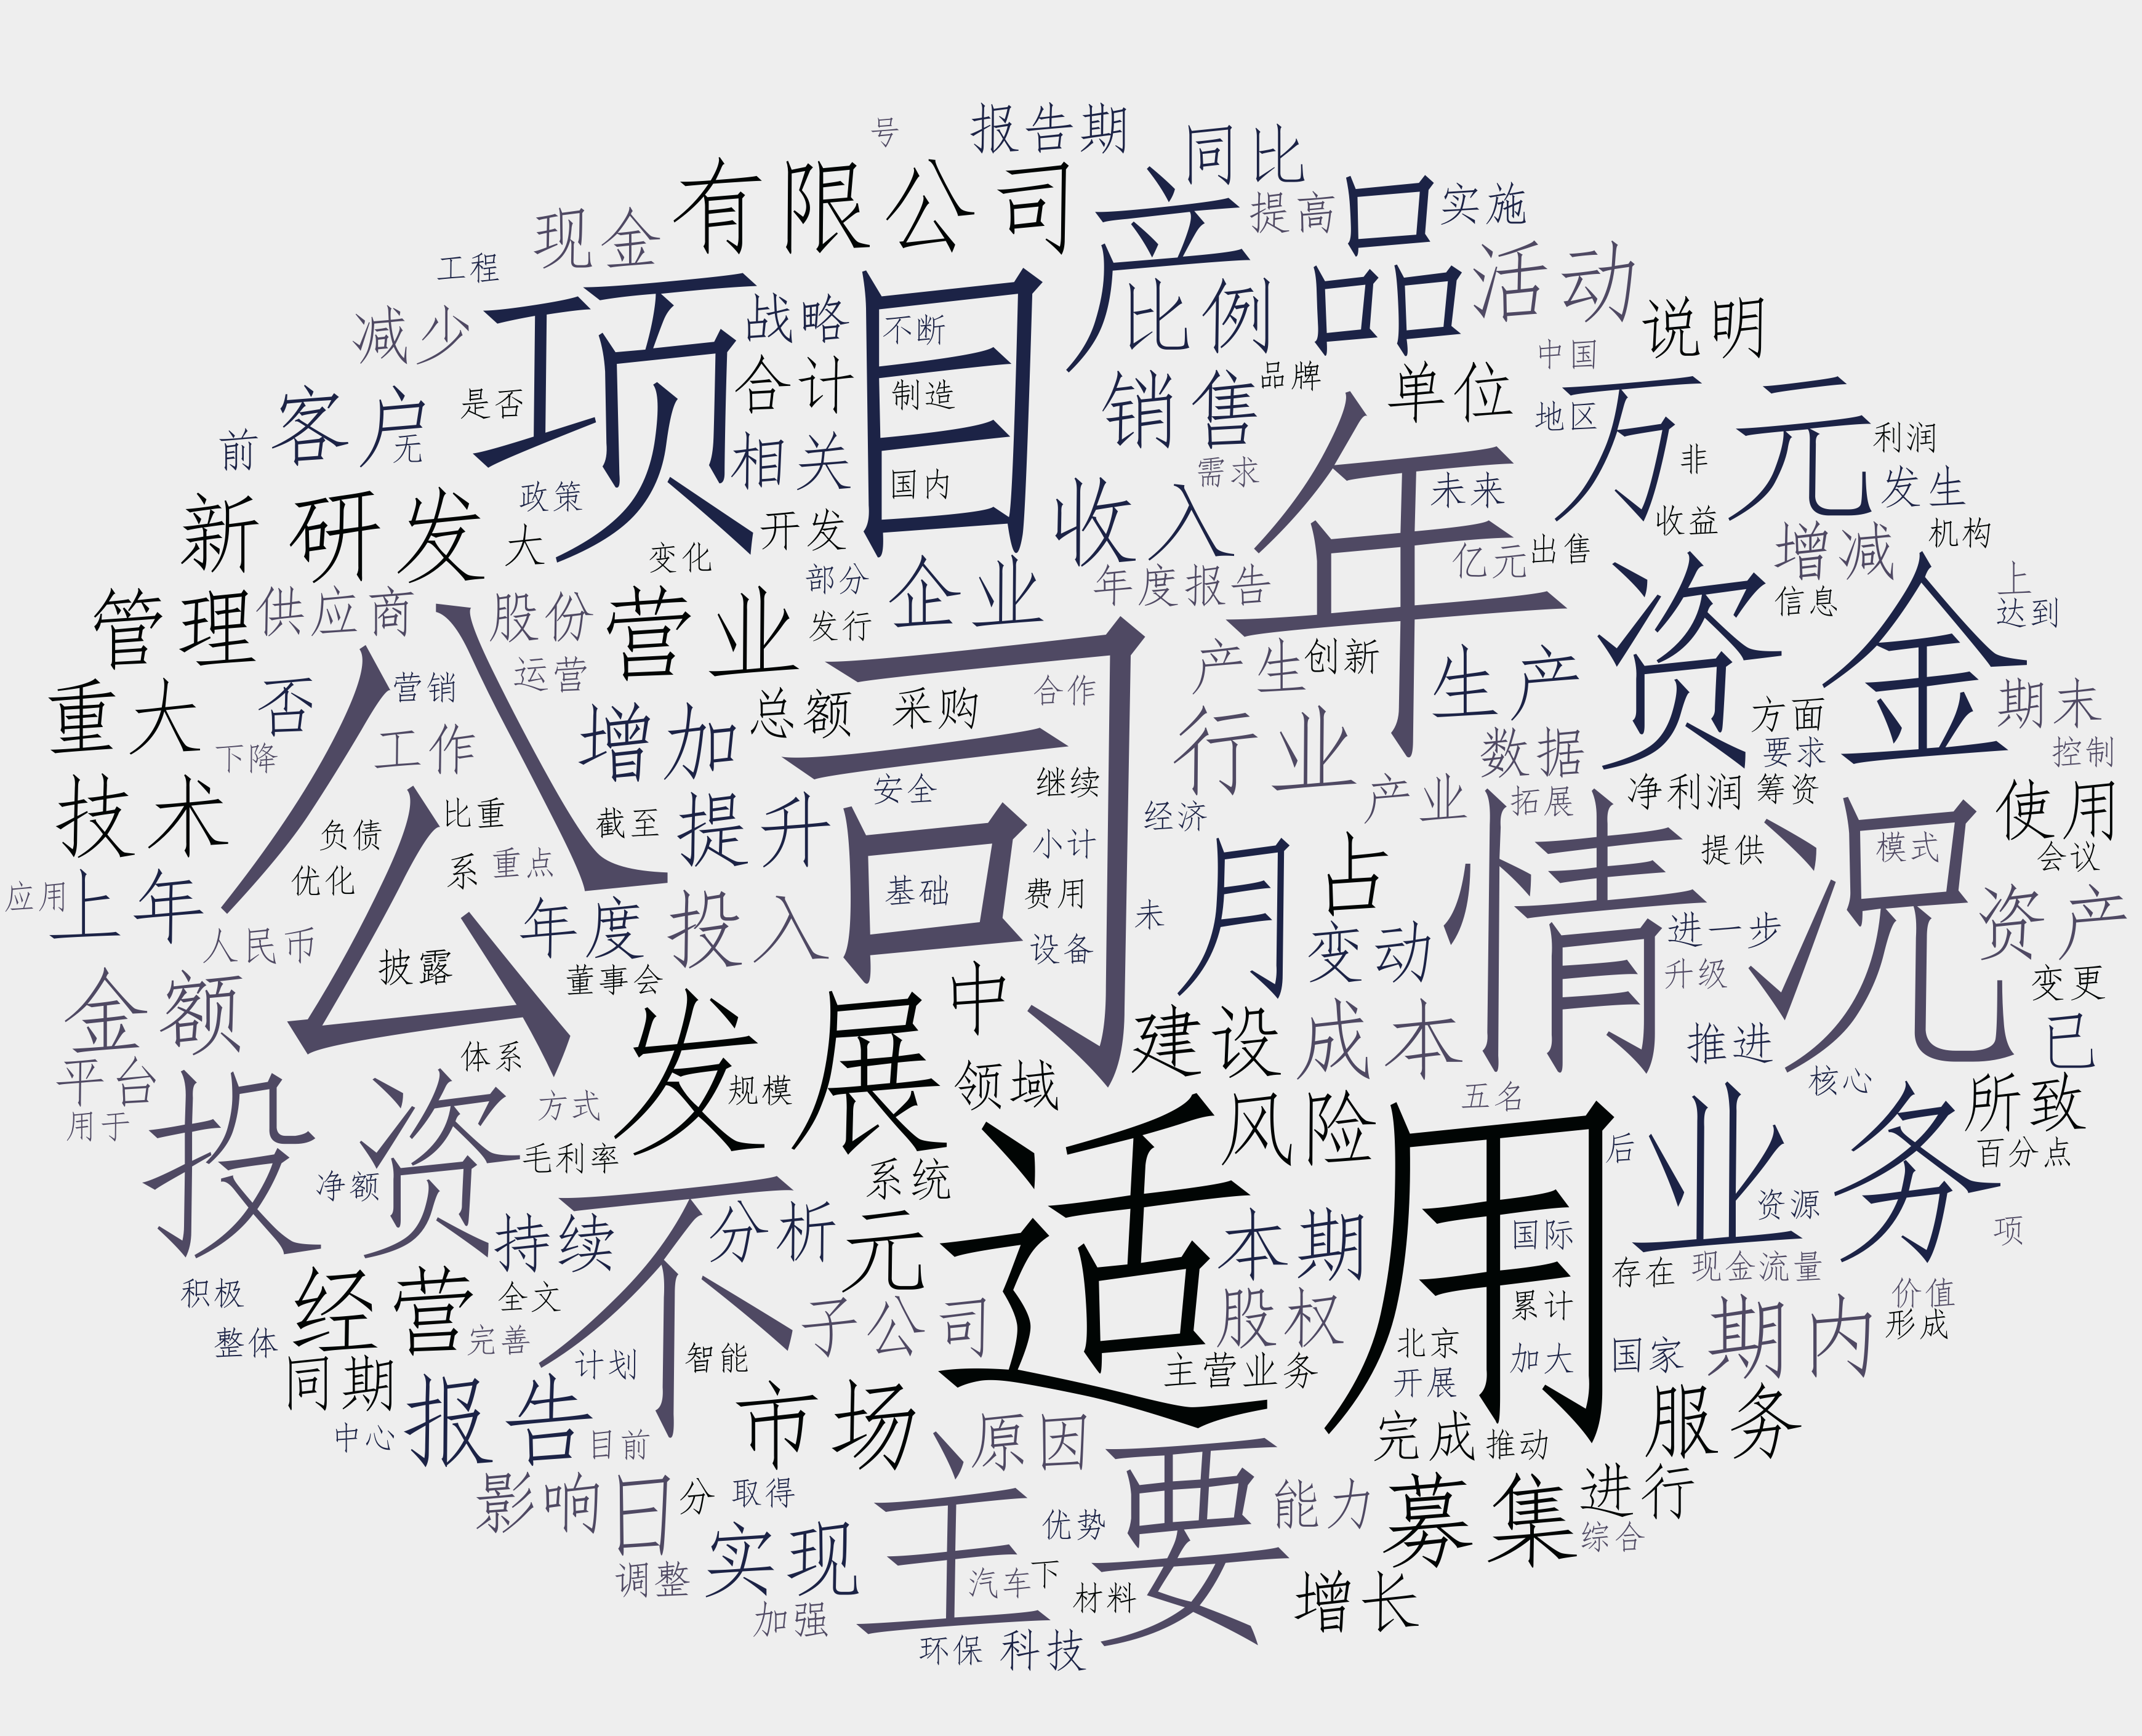

In [7]:
word_count = Counter(all_word)  # 根据分词的结果统计词频
wc.generate_from_frequencies(word_count)  # 按照词频生成词云
wc.to_file(f"../data/wordcloud.jpg")  # 将词云存储
wc.to_image() # 展示

## 词袋模型

### 使用sklearn的CountVectorizer类，产生各个句子的词袋向量

In [6]:
bow_model = CountVectorizer(analyzer="word", ngram_range=(1, 1), max_features=2000)  # 指定max_features为2000，即最后每个文档的词袋向量为2000维
data = bow_model.fit_transform([" ".join(s) for s in doc_word])  # 将每个文档的词语按照空格join起来，作为训练数据，训练完成后，将文档转成词袋编码
print(f"每个文档的编码形状为:{data[10].toarray().shape}") # 每个文档被编码成2000维的向量
print(f"前20个下标对应的单词为{bow_model.get_feature_names()[:20]}")

每个文档的编码形状为:(1, 2000)
前20个下标对应的单词为['a股', '一体', '一体化', '一定', '一家', '一带', '一年', '一批', '一是', '一期', '一步', '一流', '一种', '一系列', '一级', '一线', '一致性', '一路', '万元', '万千瓦']


### 使用sklearn的TfidfVectorizer类，产生各个句子的TF-IDF编码

In [9]:
tfidf_model = TfidfVectorizer(analyzer="word", ngram_range=(1, 1), max_features=2000)  # 指定max_features为2000，即最后的TF-IDF编码共有2000维
tfidf_data = tfidf_model.fit_transform([" ".join(s) for s in doc_word])  # 将每个文档的词语按照空格join起来，作为训练数据，训练完成后，将文档转成TF-IDF向量
print(f"每个文档的编码形状为:{tfidf_data[0].toarray().shape}") # 每个文档被编码成2000维
print(f"前20个下标对应的单词为{tfidf_model.get_feature_names()[:20]}")

每个文档的编码形状为:(1, 2000)
前20个下标对应的单词为['a股', '一体', '一体化', '一定', '一家', '一带', '一年', '一批', '一是', '一期', '一步', '一流', '一种', '一系列', '一级', '一线', '一致性', '一路', '万元', '万千瓦']


## 使用预训练的word2vec数据，来向量化
此处使用中文维基百科的语料来训练word2vec，保证词语的多样性以及全面性，且能够更好的捕获词语之间的关系信息，训练时间较长

In [8]:
# data_path = Path("../input/zhwiki-20190720-pages-articles-multistream.xml.bz2") # 原始维基百科的语料位置
# trans_path = StringIO() # 直接将处理后的数据放在内存中

# wiki = corpora.WikiCorpus(data_path) # 使用gensim来读取维基百科的语料

# l = []
# for text in tqdm(wiki.get_texts()): 
#     for temp_sentence in text: 
#         temp_sentence = convert(temp_sentence, 'zh-cn') #繁体中文转为简体中文
#         seg_list = jieba.lcut(temp_sentence) #分词
#         for temp_term in seg_list:
#             l.append(temp_term)
#         trans_path.write(" ".join(l) + '\n')
#         l = []

# trans_path.seek(0)
# model = models.Word2Vec(
#     models.word2vec.LineSentence(trans_path), 
#     sg=0,
#     vector_size=200, 
#     window=5, 
#     min_count=5, 
#     workers=6
# )# 训练模型
# with model_path.joinpath("zhiwiki_news.word2vec").open("wb") as f:
#     model.save(f) # 将模型缓存

d:\env\python\lib\site-packages\gensim\utils.py:1332: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected %s; aliasing chunkize to chunkize_serial" % entity)
0it [00:00, ?it/s]Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\ggq18\AppData\Local\Temp\jieba.cache
Loading model cost 0.645 seconds.
Prefix dict has been built successfully.
343172it [56:52, 100.57it/s]


### 加载之前成功训练的模型，可以使用model.wv.most_similar(word)方法来查看和word最相近的词语列表，也可以通过model.wv.get_vector(word)来获得词语的编码向量。

In [10]:
model = models.Word2Vec.load(str(model_path.joinpath("zhiwiki_news.word2vec")))
model.wv.most_similar("金融")

[('银行业', 0.7069196701049805),
 ('金融市场', 0.6979325413703918),
 ('国际金融', 0.6806361079216003),
 ('房地产', 0.6779360771179199),
 ('保险业', 0.6728616952896118),
 ('金融业', 0.6698169708251953),
 ('电子商务', 0.6693592071533203),
 ('金融服务', 0.668196439743042),
 ('信贷', 0.6528778076171875),
 ('国际贸易', 0.6442742943763733)]

## 主题表示

使用LDA（隐含狄利克雷分布）算法来对文本的主题进行挖掘。这里使用sklearn包中的LDA实现进行主题的挖掘,模型训练时间过长，这里加载之前训练好的模型进行展示

In [12]:
#根据语料训练模型，需要花费较多时间
# lda = LatentDirichletAllocation(
#     random_state=1234,
#     n_components=10,# 指定文章包含十个主题
#     learning_method="online", # 采用online的学习方式
#     max_iter=500, # 迭代100次
#     n_jobs=4, # 并行4个线程进行训练
#     doc_topic_prior=50/10, 
#     topic_word_prior=0.01
# )
# lda.fit(data) # 开始训练模型，这里使用的data是上面的每个文档的词袋向量
# joblib.dump(lda,model_path.joinpath("lda.model")) # 将模型缓存

['..\\data\\model\\lda.model']

In [7]:
def print_top_words(model, feature_names, n_top_words):  # 打印每个主题下权重较高的词语
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic #%:{topic_idx}")
        print(" ".join([feature_names[i] for i in topic.argsort()[: -n_top_words - 1 : -1]]))

In [11]:
# 使用之前缓存的模型查看文章的主题分布以及每个主题对应的权重较高的词语
lda = joblib.load(model_path.joinpath("lda.model"))
print_top_words(lda, bow_model.get_feature_names(), 10)  # 输出十个主题下最有可能属于这个主题的前10个词语

Topic #%:0
锂电池 电子商务 置换 各项 担保 深耕 预定 有望 坚持 经验
Topic #%:1
湖南 商业 获取 物流 置业 满足 支撑 方案 扩张 商品房
Topic #%:2
人才队伍 玻璃 广西 申请 销售 销售收入 检查 原材料 人数 劳务
Topic #%:3
电子产品 储备 基本 软件开发 计入 种植 联营企业 集团 有序 规范化
Topic #%:4
风险管理 各类 在建 生产能力 对外 创新能力 财务报表 举措 口径 深入
Topic #%:5
规划 证券报 考核 电容器 剩余 盈亏 配合 成为 武汉 流通
Topic #%:6
操作 小计 江西 采用 框架 精密 疫情 可能 实体 增多
Topic #%:7
以来 引导 抓好 高端 发布 基因 利润总额 开发新 自动 特殊
Topic #%:8
生产线 指导 目前 增加 人才培养 资讯 调整 复合 第五名 正式
Topic #%:9
序号 示范 疾病 经纪 项目 科目 手续 杭州 制品 差异
